# Đồ án cuối kì - Nhập môn khoa học dữ liệu
### Nhóm 16


## 1. Thu thập dữ liệu

Khai báo thư viện

In [1]:
import sys
sys.executable

import pycountry_convert as pc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme()

# remove warnings
import warnings
warnings.simplefilter('ignore')


#!pip install geopandas
#!pip install folium
import geopandas
import folium

## 2. Tiền xử lý và khám phá dữ liệu

### Đọc dữ liệu, bỏ cột Cause type

In [2]:
df = pd.read_csv('data.csv')
display(df.head())
print(df.shape)

,Cause of death,Age,Year,Country,Number of deaths
0,HIV/AIDS,0,2020,Albania,NaN
1,HIV/AIDS,0,2020,Antigua and Barbuda,NaN
2,HIV/AIDS,0,2020,Argentina,NaN
3,HIV/AIDS,0,2020,Armenia,NaN
4,HIV/AIDS,0,2020,Australia,0


(262752, 5)


### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Mỗi dòng cho biết với mỗi nguyên nhân, nhóm tuổi, năm và quốc gia thì có bao nhiêu người chết. Không có vấn đề các dòng có ý nghĩa khác nhau

### Dữ liệu có các dòng bị lặp không?

Ta sẽ kiểm tra vụ này và lưu kết quả vào biến `have_duplicated_rows`. Biến này sẽ có giá trị True nếu dữ liệu có các dòng bị lặp và có giá trị False nếu ngược.

In [3]:
have_duplicated_rows = df.duplicated().sum()

In [4]:
# TEST
assert have_duplicated_rows == False

Kết quả kiểm tra cho thấy không có dòng nào là bị trùng lắp dữ liệu cả.

### Mỗi cột có ý nghĩa gì?

Dưới đây là phần mô tả thông tin về các cột trong file "data.csv" mà nhóm đã lấy về được:
- **Cause of death**: Tên của nguyên nhân gây tử vong.
- **Age**: Nhóm tuổi tử vong.
- **Year**: Năm tử vong.
- **Country**: Quốc gia ghi nhận ca tử vong đó.
- **Number of deaths**: Số lượng tử vong.

### Mỗi cột hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

Ta lấy `dtype` (kiểu dữ liệu của mỗi phần tử) của mỗi cột trong dữ liệu và lưu kết quả vào series `col_dtypes`; series này có index là tên cột. 

In [5]:
col_dtypes = df.dtypes
col_dtypes

Cause of death      object
Age                 object
Year                 int64
Country             object
Number of deaths    object
dtype: object

Ta thấy cột "Cause of death" và "Country" có kiểu `object` là hợp lý rồi, cột "Age" có kiểu `object` thì cũng chấp nhận được. Nhưng 2 cột "Year" và "Number of deaths" có kiểu dữ liệu chưa phù hợp; "Year" phải có kiểu là `datetime` còn "Number of deaths" phải có kiểu là `int`

**Chuyển dtype của cột "Year" sang `datetime`**

Cột "Year" đang có dtype là `int64`, ta sẽ thực hiện bước tiền xử lý để chuyển sang dạng `datetime`.

In [6]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

In [7]:
# TEST
assert df.dtypes['Year'] == np.dtype('datetime64[ns]')

**Chuyển dtype của cột "Number of deaths" sang `float`**

Tại sao không phải kiểu `int` mà lại là `float` ?

Ta chuyển về kiểu `float` chỉ là tạm thời, vì trong cột "Number of deaths" có giá trị NAN nên ta không thể chuyển về kiểu `int` được. Ta sẽ sẽ chuyển về `int` ở phía dưới sau khi đã xóa NAN

Cột "Number of deaths" đang có dtype là `object`. Trong Pandas, kiểu dữ liệu `object` thường ám chỉ chuỗi, nhưng thật ra kiểu dữ liệu `object` có thể chứa một đối tượng bất kỳ trong Python (vì thật ra ở bên dưới kiểu dữ liệu `object` chứa địa chỉ). Nếu một cột trong dataframe có `dtype` là `object` thì có thể các phần tử trong cột này sẽ có kiểu dữ liệu khác nhau.

Ta xem chi tiết kiểu dữ liệu cột `Number of deaths`

In [8]:
def open_object_dtype(s):
    dtypes = set()

    dtypes = set(s.apply(type))
    
    return dtypes

In [9]:
open_object_dtype(df['Number of deaths'])

{float, str}

Ta tiến hành xóa ' ' trong các giá trị của cột "Number of deaths" và đổi kiểu dữ liệu thành `float`.

In [10]:
# Xóa khoảng trắng giữa các giá trị cột Number of deaths, ví dụ 1 084 -> 1084

df['Number of deaths'] = df['Number of deaths'].str.replace(' ', '').astype(float)

Ta kiểu tra lại kiểu dữ liệu của các cột sau khi chuyển đổi

In [11]:
col_dtypes = df.dtypes
col_dtypes

Cause of death              object
Age                         object
Year                datetime64[ns]
Country                     object
Number of deaths           float64
dtype: object

### Với mỗi cột có kiểu dữ liệu dạng số (numerical), các giá trị được phân bố như thế nào?

Ta sẽ xếp kiểu datetime vào nhóm numeric luôn. Như vậy, ta có 2 cột numeric là: "Year" và "Number of deaths"

Với mỗi cột numeric ta sẽ tính tỉ lệ % giá trị thiếu (từ 0 đến 100), min, max. Kết quả sẽ được lưu vào dataframe nume_col_profiles_df. Dataframe này có 3 dòng là "missing_ratio", "min", "max"; và có 2 cột là "Year" và "Number of deaths".

In [12]:
nume_col_df = df[["Year", "Number of deaths"]]

data = {"missing_ratio": nume_col_df.isna().mean() * 100,
        "min": nume_col_df.min(),
        "max": nume_col_df.max()}

nume_col_profiles_df = pd.DataFrame(data).T

nume_col_profiles_df

,Year,Number of deaths
missing_ratio,0.0,21.313254
min,2000-01-01 00:00:00,0.0
max,2020-01-01 00:00:00,206559.0


**Có gì bất thường không?**

### Với mỗi cột có kiểu dữ liệu dạng phân loại (categorical), các giá trị được phân bố như thế nào?

df có 3 cột categorical là: "Cause of death", "Age", "Country".

Với mỗi cột categorical, ta tính tỉ lệ % giá trị thiếu (từ 0 đến 100), số lượng giá trị khác nhau (không xét giá trị thiếu), list các giá trị khác nhau (không xét giá trị thiếu). Ta lưu kết quả vào dataframe cate_col_profiles_df. Dataframe này có 3 dòng là "missing_ratio", "num_diff_vals", "diff_vals"; và có 3 cột là "Cause of death", "Age", "Country".

In [13]:
cate_col_df = df[["Cause of death", "Age", "Country"]]
cate_col_profiles_dict = {}

for col in cate_col_df:
    missing_ratio = cate_col_df[col].isna().mean()*100
    diff_vals = list(cate_col_df[col].value_counts(dropna=True).index)
    num_diff_vals = len(diff_vals)
    
    cate_col_profiles_dict[col] = {"missing_ratio": missing_ratio,
                                   "num_diff_vals": num_diff_vals,
                                   "diff_vals": diff_vals}

cate_col_profiles_df = pd.DataFrame(cate_col_profiles_dict)

cate_col_profiles_df

,Cause of death,Age,Country
missing_ratio,0.0,0.0,0.0
num_diff_vals,14,8,113
diff_vals,"[HIV/AIDS, Malaria, Tuberculosis, Brain and ne...","[0, 1-4, 5-14, 15-24, 25-34, 35-54, 55-74, 75+]","[Kuwait, Montenegro, Portugal, Poland, Philipp..."


**Có gì bất thường không?**

### Tiền xử lý

Các dòng có giá trị tại cột "Cause of death" bằng 0 hoặc NAN sẽ không có ý nghĩa cho thống kê dữ liệu, vì vậy ta sẽ tiến hành xóa các dòng này. Sau đó chuyển kiểu dữ liệu của cột "Cause of death" về `int` như đã nói ở trên

In [14]:
df = df[df['Number of deaths'] != 0.0].dropna().astype({'Number of deaths': int})
df

,Cause of death,Age,Year,Country,Number of deaths
33,HIV/AIDS,0,2020-01-01,Estonia,1
38,HIV/AIDS,0,2020-01-01,Georgia,1
43,HIV/AIDS,0,2020-01-01,Guatemala,1
67,HIV/AIDS,0,2020-01-01,Mexico,14
109,HIV/AIDS,0,2020-01-01,United States of America,2
...,...,...,...,...,...
261975,War,75+,2007-01-01,Sri Lanka,14
262010,War,75+,2006-01-01,Colombia,3
262028,War,75+,2006-01-01,Germany,1
262084,War,75+,2006-01-01,Sri Lanka,9


#### Chia 'Number of deaths' theo 'Cause death' và gom nhóm theo 'Country', 'Year' và 'Age'
- Thay các giá trị Nan bằng giá trị 0 vì Nan hay 0 cũng đều không có ý nghĩa cho thống kê dữ liệu, thay thế để dễ dàng có các bước trả lời câu hỏi hơn.

In [15]:
cause_death = df['Cause of death'].unique() # danh sách cause death
df = pd.pivot_table(df, values='Number of deaths', 
                    index=['Country', 'Year', 'Age'], 
                    columns=['Cause of death'], 
                    aggfunc=np.sum, fill_value=0).reset_index()

df = df.rename_axis(None, axis=1)

display(df.head(10))
print(f'{df.shape[0]} rows x {df.shape[1]} columns')
print(f'Nguyên nhân tử vong ({len(cause_death)}):')
print(*cause_death, sep='\n')

,Country,Year,Age,Brain and nervous system cancers,Covid-19,Dengue,Drownings,Fires,HIV/AIDS,Leukaemia,Malaria,Natural disasters,Road traffic accidents,Self-inflicted injuries,Tuberculosis,Violence,War
0,Albania,2000-01-01,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
1,Albania,2000-01-01,1-4,0,0,0,12,1,0,3,0,0,0,0,2,0,0
2,Albania,2000-01-01,15-24,4,0,0,4,2,0,10,0,3,6,11,0,29,0
3,Albania,2000-01-01,25-34,6,0,0,5,0,0,9,0,1,13,20,0,34,0
4,Albania,2000-01-01,35-54,33,0,0,4,1,0,18,0,1,15,9,4,35,0
5,Albania,2000-01-01,5-14,2,0,0,7,0,0,8,0,2,6,1,1,1,0
6,Albania,2000-01-01,55-74,55,0,0,1,1,0,38,0,1,9,10,6,11,0
7,Albania,2000-01-01,75+,8,0,0,1,1,0,9,0,0,0,3,3,3,0
8,Albania,2001-01-01,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
9,Albania,2001-01-01,1-4,2,0,0,11,0,0,5,0,0,7,0,0,2,0


14749 rows x 17 columns
Nguyên nhân tử vong (14):
HIV/AIDS
Malaria
Tuberculosis
Dengue
Covid-19
Brain and nervous system cancers
Leukaemia
Road traffic accidents
Fires
Drownings
Natural disasters
Self-inflicted injuries
Violence
War


In [16]:
#df.describe()

#### Thêm cột tên khu vực của quốc gia

In [17]:
# các quốc gia không được hỗ trợ bởi thư viện
exceptive_countries = {
    'China, Hong Kong SAR': 'Asia',
    'Iran (Islamic Republic of)': 'Asia',
    'Republic of Korea': 'Asia'
}

def country_to_continent(country_name):
    if country_name in exceptive_countries:
        return exceptive_countries[country_name]

    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

df.insert(loc = 0, column = 'Continent', value = df.Country.apply(country_to_continent))

continents = df.Continent.unique() # danh sách các khu vực
print(f'Các khu vực ({len(continents)}):')
print(*continents, sep='\n')

Các khu vực (6):
Europe
North America
South America
Asia
Oceania
Africa


Ví dụ một phần của dữ liệu

In [18]:
df.query("Country == 'Italy' and '2015' in Year ") # Dữ liệu Italy năm 2015

,Continent,Country,Year,Age,Brain and nervous system cancers,Covid-19,Dengue,Drownings,Fires,HIV/AIDS,Leukaemia,Malaria,Natural disasters,Road traffic accidents,Self-inflicted injuries,Tuberculosis,Violence,War
6743,Europe,Italy,2015-01-01,0,3,0,0,0,0,0,4,0,0,7,0,0,2,0
6744,Europe,Italy,2015-01-01,1-4,13,0,0,5,0,0,20,0,0,11,0,1,1,0
6745,Europe,Italy,2015-01-01,15-24,38,0,0,27,5,3,57,0,7,452,195,1,38,0
6746,Europe,Italy,2015-01-01,25-34,57,0,0,35,7,29,66,0,6,429,335,7,61,0
6747,Europe,Italy,2015-01-01,35-54,657,0,0,70,34,401,358,1,33,932,1383,31,166,0
6748,Europe,Italy,2015-01-01,5-14,39,0,0,10,0,0,48,0,0,25,13,1,2,0
6749,Europe,Italy,2015-01-01,55-74,2011,0,0,120,51,222,1737,0,15,821,1237,65,81,0
6750,Europe,Italy,2015-01-01,75+,1320,0,0,82,134,49,3745,1,2,750,825,226,44,0


In [19]:
df[df['Continent']=='Europe']

,Continent,Country,Year,Age,Brain and nervous system cancers,Covid-19,Dengue,Drownings,Fires,HIV/AIDS,Leukaemia,Malaria,Natural disasters,Road traffic accidents,Self-inflicted injuries,Tuberculosis,Violence,War
0,Europe,Albania,2000-01-01,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
1,Europe,Albania,2000-01-01,1-4,0,0,0,12,1,0,3,0,0,0,0,2,0,0
2,Europe,Albania,2000-01-01,15-24,4,0,0,4,2,0,10,0,3,6,11,0,29,0
3,Europe,Albania,2000-01-01,25-34,6,0,0,5,0,0,9,0,1,13,20,0,34,0
4,Europe,Albania,2000-01-01,35-54,33,0,0,4,1,0,18,0,1,15,9,4,35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14152,Europe,United Kingdom,2019-01-01,25-34,108,0,0,38,9,3,60,0,1,245,1023,3,71,0
14153,Europe,United Kingdom,2019-01-01,35-54,739,0,1,72,54,77,251,2,2,409,2268,28,118,0
14154,Europe,United Kingdom,2019-01-01,5-14,62,0,0,5,2,0,43,1,0,27,16,0,8,0
14155,Europe,United Kingdom,2019-01-01,55-74,2264,0,0,49,81,46,1578,8,2,400,1325,66,36,0


## 3. Đặt các câu hỏi có ý nghĩa cần trả lời

Sau khi đã khám phá dữ liệu và hiểu hơn về dữ liệu, ta thấy có một số câu hỏi có thể được trả lời bằng dữ liệu:

### 3.1.  Top 3 quốc gia có số lượng tử vong vì Covid nhiều nhất?

- Thế giới vừa gánh chịu hậu quả to lớn mà đại dịch Covid_19 vừa đem đến, ta sẽ tiến hành xử lý và tìm ra top 3 quốc gia có số lượng tử vong vì Covid nhiều nhất?
    
        Ý nghĩa: với câu hỏi trên, ta biết được những quốc gia có số lượng tử vong vì Covid nhiều nhất. Tử vong nhiều như thế chứng tỏ nỗi mất mác của quốc gia rất nặng nề. Ta đánh giá mục đích có những quan tâm giúp đỡ để bù đắp phần nào về nỗi đau của họ. Bên cạnh đó, việc tử vong nhiều là do công tác phòng chống dịch bệnh Covid của họ vẫn còn nhiều khiếm khuyết, ta cần đưa ra cá giải pháp hỗ trợ về mặt y tế cho các quốc gia này.

Để trả lời cho câu hỏi này, ta sẽ làm như sau:
- Bước 1: Tính số lượng ca tử vong theo từng nhóm tuổi. Chọn ra top 3 quốc gia có tổng số ca tử vong nhiều nhất. Ta lưu kết quả vào series `num_death_covid`.
- Bước 2: Từ kết quả ở trên, ta vẽ group stack bar chart, trong đó trục hoành là số ca tử vong và trục tung là quốc gia. Ta đặt tên trục hoành là "Num_deaths" và tên trục tung là "Country".

Code bước 1. 

In [20]:
#Lọc ra các nước bắt đầu có ca tử vong do Covid
mask= df['Covid-19']>0

#Nhóm các quốc gia theo độ tuổi để tính tổng ca tử vong
num_death_covid=df[mask].groupby(['Country','Age'])['Covid-19'].sum()
num_death_covid=num_death_covid.reset_index()
num_death_covid = num_death_covid.pivot_table(index="Country", columns="Age",values='Covid-19', fill_value=0)
num_death_covid['sum_cols'] = num_death_covid.sum(axis=1)
num_death_covid = num_death_covid.sort_values('sum_cols' , ascending=False)
num_death_covid = num_death_covid.drop(columns='sum_cols').head(3)
display(num_death_covid)

Age,0,1-4,15-24,25-34,35-54,5-14,55-74,75+
Country,,,,,,,,
United States of America,35,19,501,2254,23043,49,118367,206559
Mexico,209,111,926,4534,45906,150,103836,44530
Spain,4,1,24,93,1442,5,12731,60539


Code bước 2. 

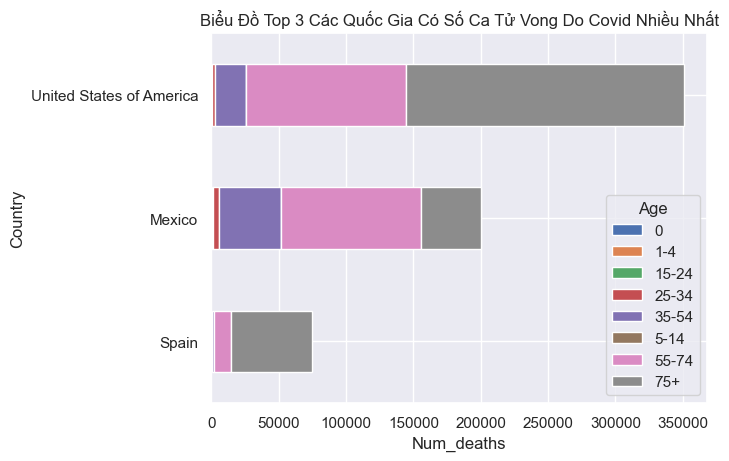

In [21]:
ax = num_death_covid.plot.barh(stacked=True)
plt.xlabel('Num_deaths')
plt.ylabel('Country')
plt.title('Biểu Đồ Top 3 Các Quốc Gia Có Số Ca Tử Vong Do Covid Nhiều Nhất')
plt.gca().invert_yaxis()
plt.show()

### 3.2.  Số ca tử vong do các bệnh truyền nhiễm ở các khu vực?

- Các bệnh truyền nhiễm bao gồm: HIV/AIDS,Covid-19, Dengue, Tuberculosis, Malaria
    
        Ý nghĩa: Bệnh truyền nhiễm là loại bệnh nhiễm trùng có khả năng lây lan từ người này sang người khác một cách trực tiếp hoặc gián tiếp qua môi trường trung gian (như thức ăn, đường hô hấp, dùng chung đồ dùng, máu, da, niêm mạc...) và có khả năng phát triển thành bệnh dịch. Điều tra về số ca tử vong do bệnh truyền nhiễm ở các quốc gia giúp ta chú trọng hơn vào công tác phòng chống dịch ở các quốc gia đó, ngăn chặn các bệnh lây lan xuống mức tối thiểu.

Số người chết do các bệnh truyền ở các khu vực trên thế giới:

In [22]:
Infectious_Causes=pd.DataFrame(df.groupby('Continent') \
                               [['HIV/AIDS','Covid-19','Dengue','Tuberculosis','Malaria']].sum())
Infectious_Causes['Total'] = Infectious_Causes.sum(axis=1)
Infectious_Causes=Infectious_Causes.sort_values(by=['Total'],ascending=False)
Infectious_Causes

,HIV/AIDS,Covid-19,Dengue,Tuberculosis,Malaria,Total
Continent,,,,,,
Africa,319672,10,43,1047698,9048,1376471
Europe,312772,175954,42,715424,1135,1205327
North America,376820,561340,4358,92118,731,1035367
Asia,145105,5781,23558,761250,4791,940485
South America,390005,23789,13347,210102,4391,641634
Oceania,1771,898,57,1667,21,4414


In [23]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
table = world.merge(Infectious_Causes['Total'], how="left", left_on=['continent'], right_on=['Continent'])
my_map = folium.Map()
folium.Choropleth(
    geo_data=table,
    name='choropleth',
    data=table,
    columns=['name', 'Total'],
    key_on='feature.properties.name',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Số lượng người mất do bệnh truyền nhiễm ở các khu vực trên thế giới'
).add_to(my_map)
 #show map, bật commit khoong được @@
#my_map

Trong 20 năm qua, châu Phi là khu vực có số lượng người mất do các bệnh truyền nhiễm cao nhất trên thế giới, mặc dù dữ liệu về Covid-19 ở khu vực này không được cập nhật. Nguyên nhân là do các quốc gia này có điều kiện y tế còn lạc hậu, người dân không được trang bị các kiến thức cần thiết để phòng chống các bệnh truyền nhiễm, dẫn đến dịch bệnh càng ngày càng lan rộng.



In [24]:
round(Infectious_Causes['Covid-19']*100/Infectious_Causes['Total'],3)

Continent
Africa            0.001
Europe           14.598
North America    54.217
Asia              0.615
South America     3.708
Oceania          20.344
dtype: float64

Tại Bắc Mỹ, mặc dù dịch bệnh Covid-19 chỉ mới bắt đầu bùng phát vào 12/2019, nhưng nó lại chiếm đến 54% trên tổng số người chết do bệnh truyền nhiễm từ năm 2000-2020. Nguyên nhân có là do chính sách “miễn dịch cộng đồng” của chính phủ và sự thờ ơ phòng chống dịch của người dân. Bỏ qua Covid-19, ta thấy các quốc gia ở khu vực này đã làm tốt trong công tác phòng chống các bệnh dịch khác như Sốt rét, Lao, Sốt xuất huyết.

In [25]:
round(Infectious_Causes['HIV/AIDS']*100/Infectious_Causes['Total'],3)

Continent
Africa           23.224
Europe           25.949
North America    36.395
Asia             15.429
South America    60.783
Oceania          40.122
dtype: float64

Từ dữ liệu trên, ta thấy HIV/AIDS là một trong những nguyên nhân hàng đầu dẫn đến tử vong ở các quốc gia trên thế giới. Nghiêm trọng nhất là ở Nam Mỹ với tỉ lệ hơn 60%. Đây cũng là nguyên nhân hàng đầu dẫn đến tử vong ở châu Đại Dương.

In [26]:
round(Infectious_Causes['Tuberculosis']*100/Infectious_Causes['Total'],3)

Continent
Africa           76.115
Europe           59.355
North America     8.897
Asia             80.942
South America    32.745
Oceania          37.766
dtype: float64

Bệnh lao là nguyên nhân hàng đầu dẫn đến tử vong ở châu Á và châu Phi và châu Âu

### 3.3.  Nhóm tuổi có tỉ lệ mất do tự gây thương tích cao nhất?
    
        Ý nghĩa: Biết được tỉ lệ người tử vong do tự gây thương tích cao nhất, từ đó ta có thể quan tâm hơn đến những người trong nhóm tuổi này.
        
        Để trả lời cho câu hỏi này, ta sẽ làm như sau:
- Bước 1: Group by số người mất do tự gây thương tích theo độ tuổi
- Bước 2: Gộp những nhóm có tỉ lệ thấp thành Others

In [27]:
#group by số người mất do tự gây thương tích theo độ tuổi
df3_3=pd.DataFrame(df.groupby(['Age'])['Self-inflicted injuries'].sum()).sort_values(by=['Self-inflicted injuries'],ascending=False)
#gộp những nhóm có tỉ lệ thấp.
other=int(df3_3[-3:].sum())
df3_3=df3_3[:-3]
df3_3.loc['Others']=other
df3_3

,Self-inflicted injuries
Age,
35-54,1760042
55-74,1195023
25-34,777760
15-24,574349
75+,481548
Others,41120


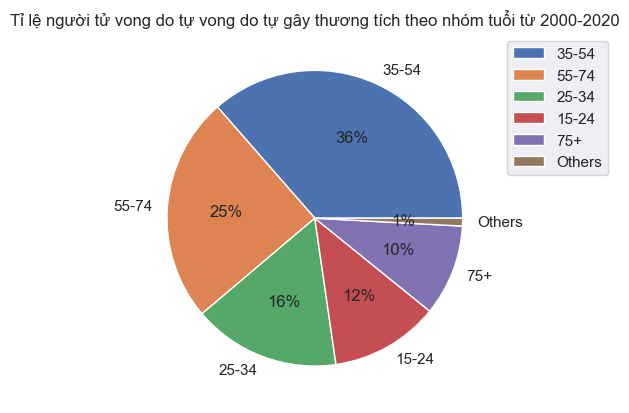

In [28]:
df3_3.plot(kind='pie', y='Self-inflicted injuries', autopct='%1.0f%%',
           title='Tỉ lệ người tử vong do tự vong do tự gây thương tích theo nhóm tuổi từ 2000-2020')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.axis('off')
plt.show()

Nhóm tuổi từ 25-75 chiếm tỉ lệ cao. Nguyên nhân chính dẫn đến tự tử có thể do áp lực công việc, cuộc sống, stress, trầm cảm. 

Chính phủ cần tăng cường giáo dục qua các phương tiện truyền thông, đưa ra các báo cáo về vấn nạn tự tử; thực hiện các chương trình giáo dục trong giới trẻ nhằm xây dựng các kỹ năng sống cho phép họ có thể xử lý được với những căng thẳng trong cuộc sống; xác định sớm và theo dõi những người có nguy cơ tự tử, đặt biệt là những người trong nhóm tuổi từ 25-75

### 3.4.  Diễn biến của các nguyên nhân gây tử vong theo thời gian
    
        Ý nghĩa: Khi biết được diễn biến của các nguyên nhân gây tử vong theo thời gian sẽ giúp ta biết được nguyên nhân nào đang có xu hướng tăng, từ đó ta có thể tập trung tiền lực và nhân lực để giảm số người tử vong do nguyên nhân đó gây ra.
        
        Để trả lời cho câu hỏi này, ta sẽ làm như sau:
- Bước 1: Tạo dict `causes_of_death_over_time` có key là năm, value là một dict chứa số người tử vong của từng nguyên nhân trong năm tương ứng với key.
- Bước 2: Tạo dataframe `causes_of_death_over_time_df` có 21 dòng tương ứng với từ năm 2000 đến năm 2020 và 14 cột tương ứng với 14 nguyên nhân gây tử vong.
- Bước 3: Vẽ đồ thị đường có 14 đường tương ứng với 14 nguyên nhân gây tử vong, trục x biểu diễn năm, trục y biểu diễn số lượng người tử vong.

Code bước 1

In [29]:
df1 = df[df.columns.difference(['Continent', 'Country', 'Age'])]
df1

,Brain and nervous system cancers,Covid-19,Dengue,Drownings,Fires,HIV/AIDS,Leukaemia,Malaria,Natural disasters,Road traffic accidents,Self-inflicted injuries,Tuberculosis,Violence,War,Year
0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,2000-01-01
1,0,0,0,12,1,0,3,0,0,0,0,2,0,0,2000-01-01
2,4,0,0,4,2,0,10,0,3,6,11,0,29,0,2000-01-01
3,6,0,0,5,0,0,9,0,1,13,20,0,34,0,2000-01-01
4,33,0,0,4,1,0,18,0,1,15,9,4,35,0,2000-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14744,32,0,7,63,29,751,79,33,7,1230,136,90,4505,0,2016-01-01
14745,151,0,12,102,51,1189,208,46,7,1340,246,221,2647,0,2016-01-01
14746,36,0,12,45,21,13,100,4,1,160,30,9,121,0,2016-01-01
14747,230,0,15,29,18,270,265,19,1,670,228,329,561,0,2016-01-01


In [30]:
causes_of_death_over_time = {}
for name, group in df1.groupby('Year'):
    causes_of_death_over_time[name.year] = group.sum().to_dict()
    
causes_of_death_over_time

{2000: {'Brain and nervous system cancers': 69982,
  'Covid-19': 0,
  'Dengue': 729,
  'Drownings': 68459,
  'Fires': 29993,
  'HIV/AIDS': 67573,
  'Leukaemia': 107830,
  'Malaria': 2804,
  'Natural disasters': 3070,
  'Road traffic accidents': 276426,
  'Self-inflicted injuries': 259461,
  'Tuberculosis': 168308,
  'Violence': 201636,
  'War': 330},
 2001: {'Brain and nervous system cancers': 70401,
  'Covid-19': 0,
  'Dengue': 968,
  'Drownings': 66341,
  'Fires': 30924,
  'HIV/AIDS': 58639,
  'Leukaemia': 108052,
  'Malaria': 1931,
  'Natural disasters': 3432,
  'Road traffic accidents': 265697,
  'Self-inflicted injuries': 254623,
  'Tuberculosis': 168888,
  'Violence': 208245,
  'War': 237},
 2002: {'Brain and nervous system cancers': 73957,
  'Covid-19': 0,
  'Dengue': 1284,
  'Drownings': 69254,
  'Fires': 31957,
  'HIV/AIDS': 75507,
  'Leukaemia': 111210,
  'Malaria': 2086,
  'Natural disasters': 2810,
  'Road traffic accidents': 281112,
  'Self-inflicted injuries': 259993,
  '

Code bước 2

In [31]:
causes_of_death_over_time_df = pd.DataFrame(causes_of_death_over_time).T
causes_of_death_over_time_df = causes_of_death_over_time_df.rename_axis("Year")
causes_of_death_over_time_df = causes_of_death_over_time_df.rename_axis("Cause of death", axis="columns")
causes_of_death_over_time_df

Cause of death,Brain and nervous system cancers,Covid-19,Dengue,Drownings,Fires,HIV/AIDS,Leukaemia,Malaria,Natural disasters,Road traffic accidents,Self-inflicted injuries,Tuberculosis,Violence,War
Year,,,,,,,,,,,,,,
2000,69982,0,729,68459,29993,67573,107830,2804,3070,276426,259461,168308,201636,330
2001,70401,0,968,66341,30924,58639,108052,1931,3432,265697,254623,168888,208245,237
2002,73957,0,1284,69254,31957,75507,111210,2086,2810,281112,259993,185708,213171,304
2003,75145,0,1319,64724,32710,78399,112480,1802,2696,279288,259999,191264,206325,299
2004,75530,0,427,59930,29653,73326,109495,1475,5667,267419,249155,161728,183613,931
2005,77468,0,558,60834,30004,74203,109055,1222,22524,267593,242890,165738,180901,992
2006,80933,0,1635,60237,28647,73511,113154,1164,4198,272828,237082,184193,186658,2006
2007,82913,0,2225,61481,29606,72752,115198,838,2776,278961,240917,179111,179001,2403
2008,85495,0,2123,59568,29401,73945,117581,738,2531,266743,238633,175017,187370,237


Code bước 3

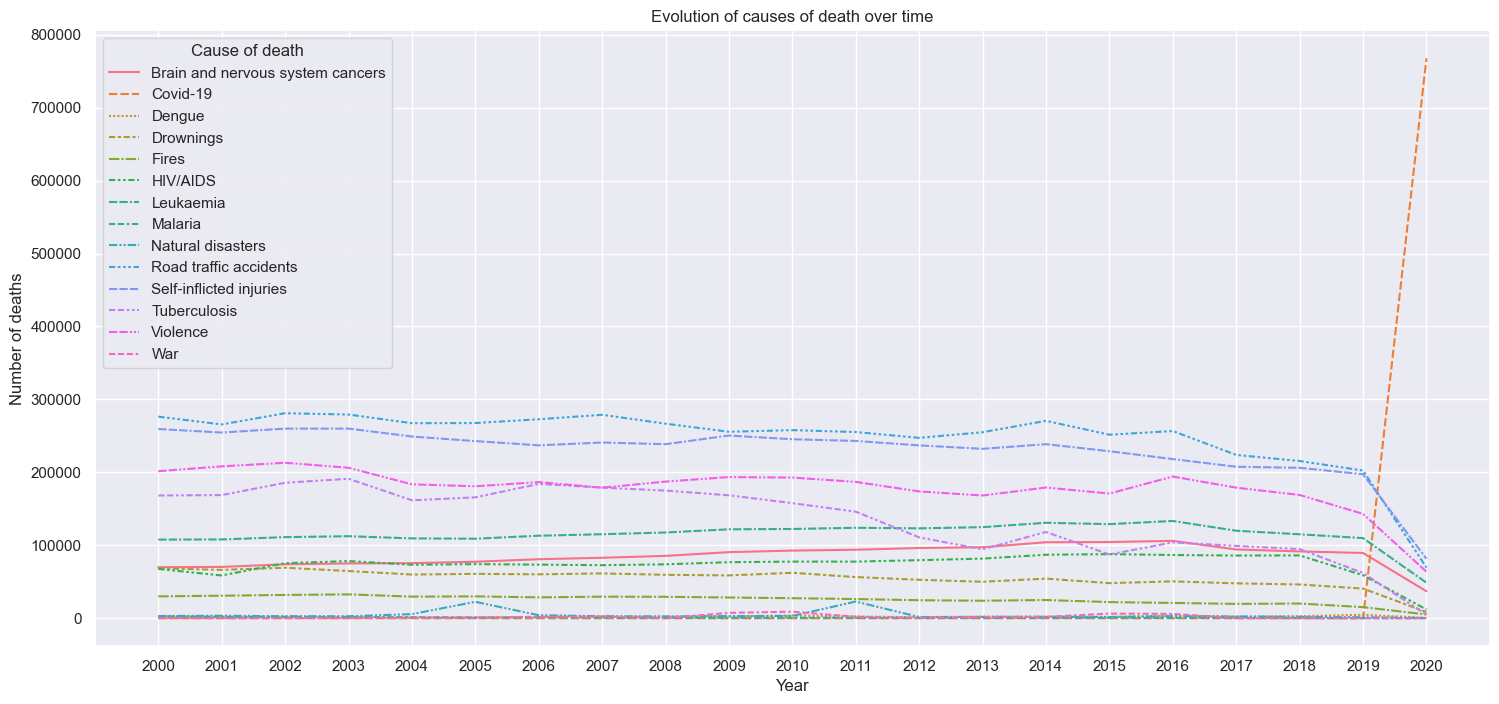

In [32]:
plt.figure(figsize = (18, 8))
sns.lineplot(data=causes_of_death_over_time_df)

plt.xticks(causes_of_death_over_time_df.index)
plt.ylabel("Number of deaths")
plt.title("Evolution of causes of death over time")

plt.show()

Từ đồ thị trên ta thấy được từ năm 2000 đến năm 2020:
- Số người tử vong do 'Covid-19' tăng rất nhanh từ năm 2019 đến năm 2020 và là nguyên nhân gây tử vong hàng đầu trong 2 năm này.
- Số người tử vong do 13 nguyên nhân còn lại thì ổn định từ năm 2000 đến năm 2010, và đa số là có xu hướng giảm dần từ năm 2010 đến năm 2020, đặc biệt giảm một cách rõ rệt trong 2 năm là 2019 và 2020. Có thể giải thích cho việc này là vì con người đã có những biện pháp để hạn chế tử vong do 13 nguyên nhân trên gây ra. Còn trong 2 năm 2019 và 2020 giảm mạnh là vì mọi người thực hiện giản cách xã hội để chống 'Covid-19' nên 13 nguyên nhân này không có nhiều cơ hội để gây tử vong.

Những chính sách để giảm số người tử vong trong tương lai:
- Tiếp tục thực hiện các biệt pháp hiện có để làm giảm dần số người tử vong do 13 nguyên nhân còn lại.
- Tập trung nguồn lực để hạn chế và tìm ra biện pháp chống lại 'Covid-19'.

### 3.5.  Tỷ lệ tử vong của các nhóm tuổi ở từng quốc gia, từng khu vực

### 3.7. Mối quan hệ giữa một số nguyên nhân tử vong.<br>
Ý nghĩa: biết được sự liên quan giữa các nguyên nhân tử vong với nhau, giúp kết luận các nguyên nhân đồng hành với nhau hay không từ đó có chiến lược phù hợp để xử lý.<br>
Hàm dưới đây sẽ vẽ biểu đồ phân tán theo số ca tử vong của 2 nguyên nhân của mỗi quốc gia trong từng năm.<br>
Những điểm dữ liệu có ít nhất một giá trị bằng 0 sẽ bị xoá.

In [33]:
def pl_scatter(col1, col2):
    pl_df = df[['Country', 'Year', col1, col2]]
    pl_df = pl_df.groupby(['Country', 'Year']).sum().reset_index()
    pl_df[(pl_df != 0).all(1)]
    plt.scatter(pl_df[col1], pl_df[col2])
    plt.title(f'{col1} versus {col2}')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()

#### Mối liên hệ giữa bệnh sốt xuất huyết và sốt rét?
Ta biết rằng bệnh sốt xuất huyết (Dengue) và bệnh sốt rét (Malaria) đều là hai loại bệnh truyền nhiễm phổ biến ở vùng nhiệt đới và lây truyền bởi muỗi. Vậy dịch sốt xuất huyết và sốt rét có đồng hành với nhau không?

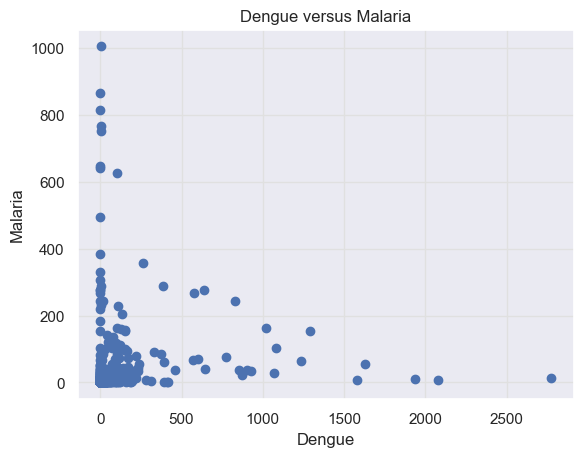

In [37]:
pl_scatter('Dengue', 'Malaria')

$ \Rightarrow $ Quan sát đồ thị, chúng ta sẽ thấy sốt rét và sốt xuất huyết thường không xuất hiện cùng với nhau, khi sốt rét tăng thì sốt xuất huyết giảm và ngược lại. Như vậy, khi một trong hai dịch bệnh này xảy ra thì chúng ta nên tập trung xử lý dịch bệnh đó, tránh dàn trải nguồn lực.

#### Mối liên hệ giữa bệnh bạch cầu và ung thư não/hệ thần kinh?
Tương tự là hai bệnh ung thư, bạch cầu (Leukaemia) và ung thư não/ hệ thần kinh (Brain and nervous system cancers)

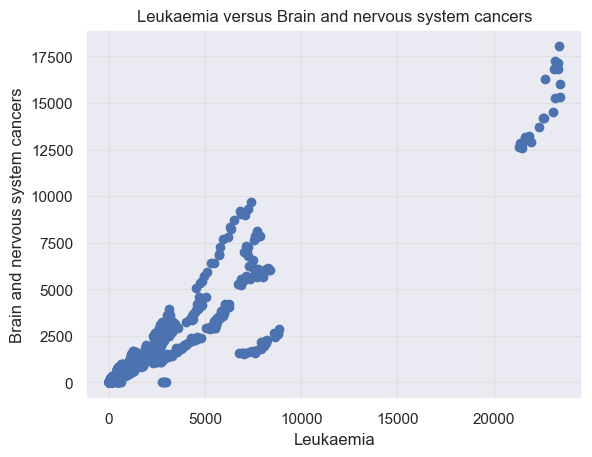

In [38]:
pl_scatter('Leukaemia', 'Brain and nervous system cancers')

Bệnh bạch cầu cũng là một loại ung thư và biểu đồ cho bệnh bạch có xu hướng tăng khi bệnh ung thư não/hệ thần kinh tăng. Có thể thấy các bệnh ung thư nói chung có xu hướng liên quan chặt chẽ với nhau.

### 3.8. So sánh phân phối tuổi tử vong
- Như chúng ta đã biết, tuổi thọ (tương đương tuổi tử vong) là một chỉ số quan trọng để đánh giá chất lượng cuộc sống, chỉ số phát triển con người và mức độ tiến bộ của một quốc gia, khu vực. Khi chất lượng cuộc sống được cải thiện, hệ thống y tế tốt, tuổi thọ sẽ tăng lên và số lượng tử vong sẽ lệch về nhóm tuổi cao hơn.
- Ngoài ra, phân phối này còn cho ta thấy tỉ lệ sống sót của trẻ em (dưới 5 tuổi), là một chỉ số được Liên Hợp Quốc dùng để đánh giá tiêu chuẩn phát triển trẻ em. Chúng ta cùng tìm hiểu qua các bước sau.

In [39]:
# tính tỉ lệ tử vong theo từng nhóm tuổi
def pl_line(arg_df):
    # lấy các giá trị cần thiết và tính tổng theo độ tuổi
    tmp_df = arg_df.iloc[:, 3:]
    tmp_df = tmp_df.groupby('Age').sum().reset_index()
    # Tính tổng và tỉ lệ của các độ tuổi
    tmp_df['Total'] = tmp_df.iloc[:, 1:].sum(axis=1)
    S = tmp_df['Total'].sum()
    tmp_df['Rate'] = tmp_df['Total'] / S
    # sắp xếp tuổi theo đúng thứ tự
    tmp_df['Age'] = tmp_df['Age'].apply(
        lambda x: '0' + x if len(x.split('-')[0]) < 2 else x)
    tmp_df = tmp_df.sort_values(by=['Age']).reset_index()
    # trả về tuổi và ti lệ
    return tmp_df[['Age', 'Rate']]


In [40]:
query_2000 = '"2000" in Year'   # query lấy dữ liệu năm 2000
query_2019 = '"2019" in Year'   # query lấy dữ liệu năm 2019
query_Canada = 'Country == "Canada"'    # query lấy dữ liệu Canada
query_Nicaragua = 'Country == "Nicaragua"'  # query lấy dữ liệu Nicaragua
query_Af1519 = 'Continent == "Africa" and Year >= "2015-01-01" and Year <= "2019-12-31"'    # query lấy dữ liệu Châu Phi từ năm 2015 - 2019
query_As1519 = 'Continent == "Asia" and Year >= "2015-01-01" and Year <= "2019-12-31"'      # query lấy dữ liệu Châu Á từ năm 2015 - 2019
query_Eu1519 = 'Continent == "Europe" and Year >= "2015-01-01" and Year <= "2019-12-31"'    # query lấy dữ liệu Châu Âu từ năm 2015 - 2019

In [41]:
# Thay đổi kiểu đồ thị
plt.rc('grid', linestyle='-', color='#e0e0e0', linewidth=1)
plt.grid(True)
plt.close()
ageShow = ['0', '1-4', '5-14', '15-24', '25-34', '35-54', '55-74', '75+']

#### Tuổi tử vong đã thay đổi như thế nào từ năm 2000 đến 2019?

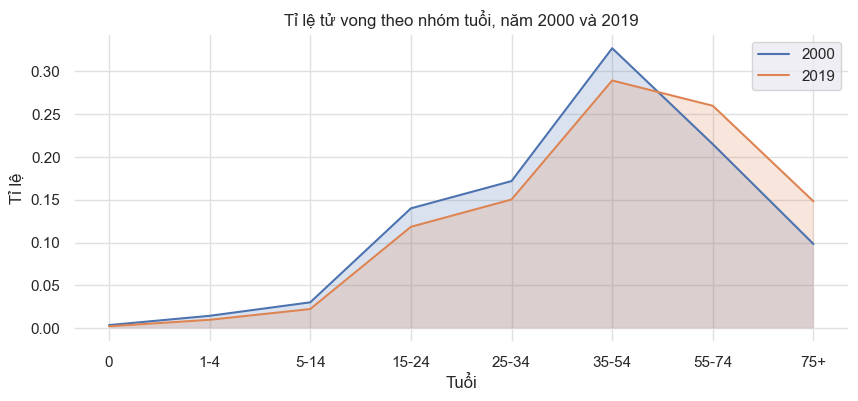

Tỉ lệ tử vong của trẻ em dưới 5 tuổi (2000): 1.8%
Tỉ lệ tử vong của trẻ em dưới 5 tuổi (2000): 1.2%


In [55]:
fig, ax = plt.subplots(figsize=(10, 4))

child_mortality = []
pl_df = pl_line(df.query(query_2000))
plt.plot(ageShow, pl_df['Rate'], label='2000')
ax.fill_between(ageShow, pl_df['Rate'], alpha=0.2)
child_mortality.append(pl_df.iloc[:2, 1].sum()*100)

pl_df = pl_line(df.query(query_2019))
plt.plot(ageShow, pl_df['Rate'], label='2019')
ax.fill_between(ageShow, pl_df['Rate'], alpha=0.2)
child_mortality.append(pl_df.iloc[:2, 1].sum()*100)

ax.set_facecolor('white')
ax.set_xlabel('Tuổi')
ax.set_ylabel('Tỉ lệ')
ax.set_title('Tỉ lệ tử vong theo nhóm tuổi, năm 2000 và 2019')
plt.legend()
plt.show()
print('Tỉ lệ tử vong của trẻ em dưới 5 tuổi (2000): {:.1f}%'.format(child_mortality[0]))
print('Tỉ lệ tử vong của trẻ em dưới 5 tuổi (2000): {:.1f}%'.format(child_mortality[1]))


Quan sát đồ thị có thể thấy năm 2019 so với năm 2000, tỉ lệ tử vong ở nhóm tuổi dưới 54 giảm và trên 54 tăng, đồ thị 2019 lệch qua phải. Vậy tuổi thọ đã được gia tăng và chất lượng cuộc sống được cải thiện trong 19 năm qua.

#### Tuổi tử vong ở các nước khác nhau?
Phân phối tuổi tử vong hay tuổi thọ có thể giúp đánh giá mức độ phát triển của một quốc gia. Một quốc gia phát triển sẽ có chất lượng cuộc sống tốt hơn, tuổi thọ cao hơn.

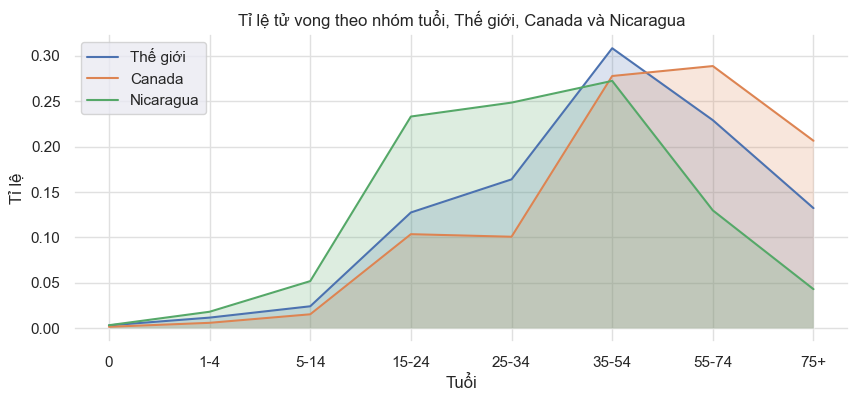

Tỉ lệ tử vong của trẻ em dưới 5 tuổi (Thế giới): 1.5%
Tỉ lệ tử vong của trẻ em dưới 5 tuổi (Canada): 0.8%
Tỉ lệ tử vong của trẻ em dưới 5 tuổi (Nicaragua): 2.1%


In [56]:
fig, ax = plt.subplots(figsize=(10, 4))

child_mortality = []
pl_df = pl_line(df)
plt.plot(ageShow, pl_df['Rate'], label='Thế giới')
ax.fill_between(ageShow, pl_df['Rate'], alpha=0.2)
child_mortality.append(pl_df.iloc[:2, 1].sum()*100)

pl_df = pl_line(df.query(query_Canada))
plt.plot(ageShow, pl_df['Rate'], label='Canada')
ax.fill_between(ageShow, pl_df['Rate'], alpha=0.2)
child_mortality.append(pl_df.iloc[:2, 1].sum()*100)

pl_df = pl_line(df.query(query_Nicaragua))
plt.plot(ageShow, pl_df['Rate'], label='Nicaragua')
ax.fill_between(ageShow, pl_df['Rate'], alpha=0.2)
child_mortality.append(pl_df.iloc[:2, 1].sum()*100)

ax.set_facecolor('white')
ax.set_xlabel('Tuổi')
ax.set_ylabel('Tỉ lệ')
ax.set_title('Tỉ lệ tử vong theo nhóm tuổi, Thế giới, Canada và Nicaragua')
plt.legend()
plt.show()
print('Tỉ lệ tử vong của trẻ em dưới 5 tuổi (Thế giới): {:.1f}%'.format(child_mortality[0]))
print('Tỉ lệ tử vong của trẻ em dưới 5 tuổi (Canada): {:.1f}%'.format(child_mortality[1]))
print('Tỉ lệ tử vong của trẻ em dưới 5 tuổi (Nicaragua): {:.1f}%'.format(child_mortality[2]))


Đồ thị của Canada lệch về bên phải so với thế giới còn Nicaragua lệch về bên trái. Vậy tuổi thọ của Nicaragua thấp, Canada cao và có thể đánh giá Canada phát triển hơn Nicaragua.

#### Tuổi tử vong ở các châu lục khác nhau trong những năm gần đây
Tương tự các quốc gia, ta có thể đánh giá mức độ phát triển và chất lương cuộc sống của các châu lục thông qua tuổi tử vong (tuổi thọ).

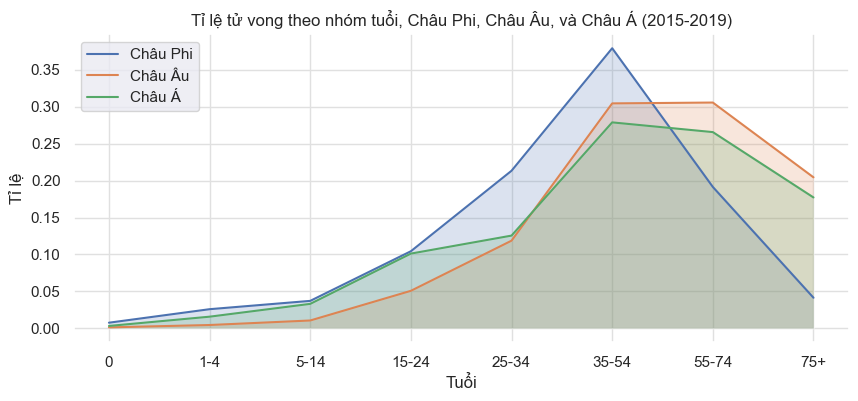

Tỉ lệ tử vong của trẻ em dưới 5 tuổi (châu Phi): 3.3%
Tỉ lệ tử vong của trẻ em dưới 5 tuổi (châu Âu): 0.6%
Tỉ lệ tử vong của trẻ em dưới 5 tuổi (châu Á): 1.9%


In [57]:
fig, ax = plt.subplots(figsize=(10, 4))

child_mortality = []
pl_df = pl_line(df.query(query_Af1519))
plt.plot(ageShow, pl_df['Rate'], label='Châu Phi')
ax.fill_between(ageShow, pl_df['Rate'], alpha=0.2)
child_mortality.append(pl_df.iloc[:2, 1].sum()*100)

pl_df = pl_line(df.query(query_Eu1519))
plt.plot(ageShow, pl_df['Rate'], label='Châu Âu')
ax.fill_between(ageShow, pl_df['Rate'], alpha=0.2)
child_mortality.append(pl_df.iloc[:2, 1].sum()*100)

pl_df = pl_line(df.query(query_As1519))
plt.plot(ageShow, pl_df['Rate'], label='Châu Á')
ax.fill_between(ageShow, pl_df['Rate'], alpha=0.2)
child_mortality.append(pl_df.iloc[:2, 1].sum()*100)

ax.set_facecolor('white')
ax.set_xlabel('Tuổi')
ax.set_ylabel('Tỉ lệ')
ax.set_title('Tỉ lệ tử vong theo nhóm tuổi, Châu Phi, Châu Âu, và Châu Á (2015-2019)')
plt.legend()
plt.show()

print('Tỉ lệ tử vong của trẻ em dưới 5 tuổi (châu Phi): {:.1f}%'.format(child_mortality[0]))
print('Tỉ lệ tử vong của trẻ em dưới 5 tuổi (châu Âu): {:.1f}%'.format(child_mortality[1]))
print('Tỉ lệ tử vong của trẻ em dưới 5 tuổi (châu Á): {:.1f}%'.format(child_mortality[2]))

Nhìn vào đồ thị, có thể thấy châu Á phát triển hơn châu Phi nhưng chưa bằng châu Âu.